Please upload your kaggle.json file


Saving kaggle.json to kaggle (2).json

Kaggle API credentials configured successfully.
Libraries imported successfully.
Dataset already exists. Skipping download.

--- Starting Data Curation ---
Created a subset with 20000 images.
--- Data Curation Complete ---

--- Starting Image Loading and Preprocessing ---
Loading 20000 images and preprocessing them...


100%|██████████| 20000/20000 [00:19<00:00, 1041.55it/s]



Data loaded into X (shape: (20000, 4096)) and y (shape: (20000,))
--- Image Loading Complete ---

--- Starting Machine Learning Pipeline ---
Data split into training (15000 samples) and testing (5000 samples) sets.

Computing Eigenfaces with PCA...
Projecting data into 'Face Space'...

Training SVM classifier for Smile Detection...
Best SVM estimator found: SVC(C=10, class_weight='balanced', gamma=0.001)

Evaluating the model...

Classification Report (0=Not Smiling, 1=Smiling):
              precision    recall  f1-score   support

 Not Smiling       0.87      0.89      0.88      2603
     Smiling       0.88      0.85      0.87      2397

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000


--- Generating Visualizations ---


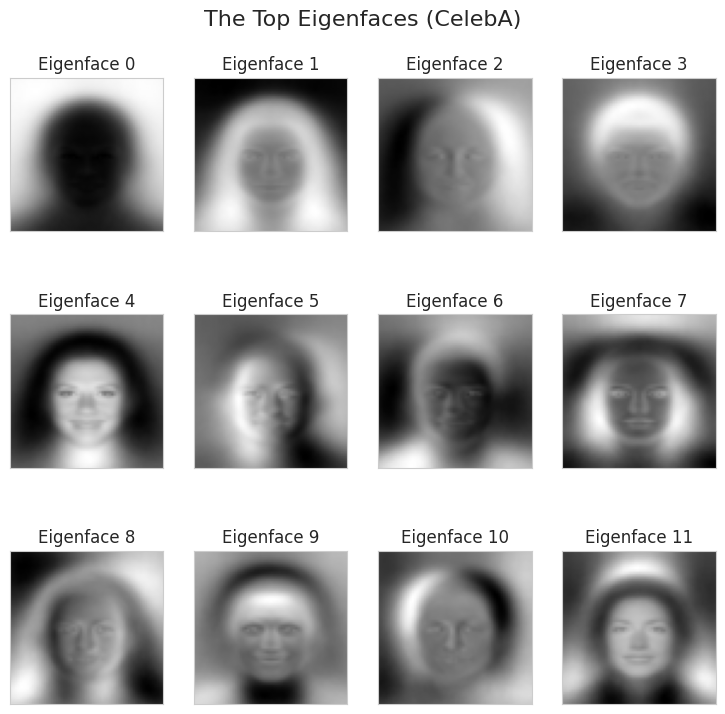

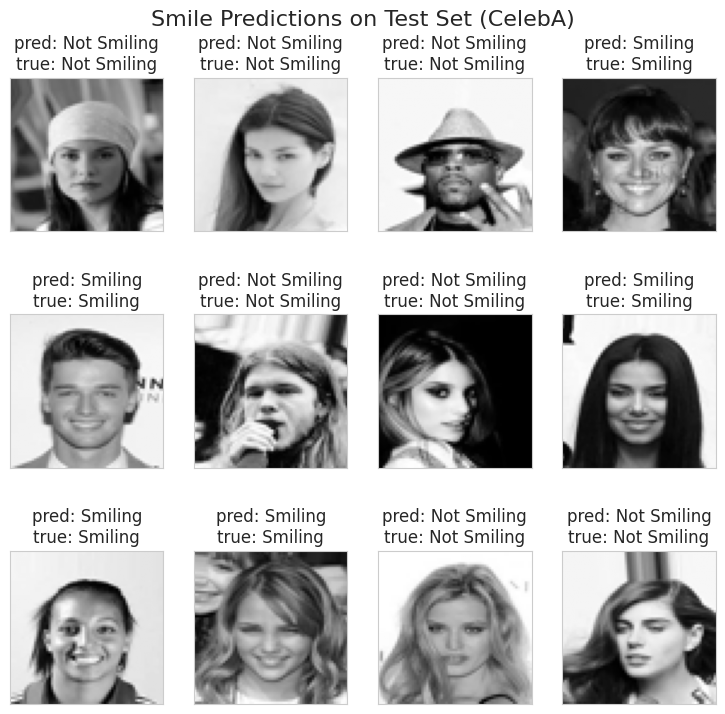


--- Script Finished ---


In [12]:
# =============================================================================
# Section 1: Colab Setup, Configuration, and Automated Download
# =============================================================================
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# --- Colab-specific: Upload Kaggle API credentials ---
print("Please upload your kaggle.json file")
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nKaggle API credentials configured successfully.")

from kaggle.api.kaggle_api_extended import KaggleApi
print("Libraries imported successfully.")

# --- Configuration ---
DATA_DIR = './celeba_data/'
# NOTE: Based on your screenshot, the image folder is directly inside 'img_align_celeba'
IMG_FOLDER = os.path.join(DATA_DIR, 'img_align_celeba/img_align_celeba/')
# Path to the attributes file
ATTRIBUTE_FILE = os.path.join(DATA_DIR, 'list_attr_celeba.csv')
KAGGLE_DATASET = 'jessicali9530/celeba-dataset'

# --- Parameters for Data Curation and Model ---
N_IMAGES_TO_USE = 20000  # We'll use the first 20,000 images for a manageable dataset
IMG_HEIGHT = 64
IMG_WIDTH = 64
N_COMPONENTS = 150

# --- Automated Download and Unzip ---
if not os.path.exists(DATA_DIR):
    print(f"Dataset not found. Downloading '{KAGGLE_DATASET}' from Kaggle...")
    os.makedirs(DATA_DIR, exist_ok=True)
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(KAGGLE_DATASET, path=DATA_DIR, quiet=False)
    print("Download complete. Unzipping files...")
    zip_file_path = os.path.join(DATA_DIR, f"{KAGGLE_DATASET.split('/')[1]}.zip")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    os.remove(zip_file_path)
    print("Unzipping complete. Dataset is ready.")
else:
    print("Dataset already exists. Skipping download.")

# =============================================================================
# Section 2: Data Curation (Using Attributes)
# =============================================================================
print("\n--- Starting Data Curation ---")
df_attr = pd.read_csv(ATTRIBUTE_FILE)

# Select a subset of the data
df_subset = df_attr.head(N_IMAGES_TO_USE)

# Get the image filenames and the 'Smiling' labels
image_paths = df_subset['image_id'].values
labels = df_subset['Smiling'].values

# The labels are -1 for not smiling and 1 for smiling.
# We need to convert them to 0 and 1 for our classifier.
y = (labels + 1) // 2
print(f"Created a subset with {len(df_subset)} images.")
print("--- Data Curation Complete ---")


# =============================================================================
# Section 3: Image Loading and Preprocessing
# =============================================================================
print("\n--- Starting Image Loading and Preprocessing ---")
X_list = []
print(f"Loading {len(image_paths)} images and preprocessing them...")
for img_name in tqdm(image_paths):
    full_path = os.path.join(IMG_FOLDER, img_name)
    try:
        img = Image.open(full_path).convert('L')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        X_list.append(np.array(img).flatten())
    except FileNotFoundError:
        print(f"Warning: Could not find {full_path}. Skipping.")
X = np.array(X_list)
print(f"\nData loaded into X (shape: {X.shape}) and y (shape: {y.shape})")
print("--- Image Loading Complete ---")


# =============================================================================
# Section 4: The Machine Learning Pipeline
# =============================================================================
print("\n--- Starting Machine Learning Pipeline ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples) sets.")

print("\nComputing Eigenfaces with PCA...")
pca = PCA(n_components=N_COMPONENTS, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((N_COMPONENTS, IMG_HEIGHT, IMG_WIDTH))

print("Projecting data into 'Face Space'...")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("\nTraining SVM classifier for Smile Detection...")
param_grid = {'C': [1, 10, 100], 'gamma': [0.001, 0.01]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
clf = clf.fit(X_train_pca, y_train)
print("Best SVM estimator found:", clf.best_estimator_)

print("\nEvaluating the model...")
y_pred = clf.predict(X_test_pca)
print("\nClassification Report (0=Not Smiling, 1=Smiling):")
print(classification_report(y_test, y_pred, target_names=['Not Smiling', 'Smiling']))


# =============================================================================
# Section 5: Visualization
# =============================================================================
print("\n--- Generating Visualizations ---")
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    num_images_to_plot = min(len(images), n_row * n_col)
    for i in range(num_images_to_plot):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = [f"Eigenface {i}" for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, IMG_HEIGHT, IMG_WIDTH)
plt.suptitle("The Top Eigenfaces (CelebA)", size=16)
plt.show()

def title(y_pred, y_test, i):
    label_map = {0: 'Not Smiling', 1: 'Smiling'}
    pred_name = f"pred: {label_map[y_pred[i]]}"
    true_name = f"true: {label_map[y_test[i]]}"
    return f"{pred_name}\n{true_name}"
prediction_titles = [title(y_pred, y_test, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, IMG_HEIGHT, IMG_WIDTH)
plt.suptitle("Smile Predictions on Test Set (CelebA)", size=16)
plt.show()

print("\n--- Script Finished ---")